---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [35]:
! pip install graphviz
! apt-get install graphviz

/bin/sh: apt-get: command not found


In [2]:
from IPython.core.debugger import set_trace

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def import_data():
    
    feature_names = ['agency_name', 'violation_street_number', 'violation_street_name', 'violation_zip_code',
                     'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 'non_us_str_code', 'country',
                     'ticket_issued_date', 'hearing_date', 'violation_code', 'disposition',
                     'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost', 'judgment_amount', 
                     'grafitti_status', 'address', 'lat', 'lon']
    
    target_name = 'compliance'
        
    df_train = pd.read_csv('train.csv', encoding='cp1252', low_memory=False)
    
    df_add = pd.read_csv('addresses.csv', encoding='cp1252', low_memory=False)
    
    df_lat = pd.read_csv('latlons.csv', encoding='cp1252', low_memory=False)
    
    df_temp = df_train.merge(df_add, on='ticket_id')
    
    df = df_temp.merge(df_lat, on='address')
    
    df = df[df[target_name].notnull()]
    
    df['judgment_amount'] = df['judgment_amount'].astype(float)
    
    df['discount_percentage'] = df['discount_amount'].divide(df['judgment_amount']).replace(np.nan, 0)

    df['ticket_issued_month'] = df['ticket_issued_date'].str.slice(stop=7)
    
    df['ticket_issued_date'] = pd.to_datetime(df['ticket_issued_date'])
    
    df['ticket_issued_days_to_2004'] = (df['ticket_issued_date'] - df['ticket_issued_date'].min()).astype('timedelta64[D]')
                
    calculated_feature_name = ['ticket_issued_days_to_2004', 'discount_percentage']
        
    working_feature_names = ['agency_name', 'city', 'violation_code', 'disposition', 'judgment_amount', 'address', 'lat', 'lon']
        
    working_feature_names += calculated_feature_name
                
    null_feature_set = []
    
    print(df.shape)
    df = df[pd.notnull(df[working_feature_names]).all(axis=1)]
    print(df.shape)

    
    for key in working_feature_names:
        print(key + ' distribution:\n' + str(df[key].value_counts()) + '\n')
        print("null: " + str(df[key].isnull().sum()) + '\n')
        
    X = df[feature_names + calculated_feature_name]
    
    y = df[target_name]
    
    print('y value distribution:\n' + str(y.value_counts()))

    
    X_work, X_test, y_work, y_test = train_test_split(X, y, random_state=0, test_size=0.1)

    return X_work, X_test, y_work, y_test, df

X_work, X_test, y_work, y_test, df = import_data()

(159880, 40)
(159878, 40)
agency_name distribution:
Buildings, Safety Engineering & Env Department    95862
Department of Public Works                        52444
Health Department                                  7107
Detroit Police Department                          4464
Neighborhood City Halls                               1
Name: agency_name, dtype: int64

null: 0

city distribution:
DETROIT               87425
SOUTHFIELD             8790
Detroit                6374
DEARBORN               2408
detroit                2197
FARMINGTON HILLS       1468
OAK PARK               1436
WARREN                 1235
W. BLOOMFIELD          1033
DET                    1010
REDFORD                 951
TROY                    888
LIVONIA                 784
WEST BLOOMFIELD         724
Southfield              687
CANTON                  642
FARMINGTON              591
BLOOMFIELD HILLS        587
CHICAGO                 564
DET.                    546
SAN DIEGO               538
EASTPOINTE         

y value distribution:
0.0    148281
1.0     11597
Name: compliance, dtype: int64


In [4]:
from sklearn.preprocessing import MinMaxScaler

def normalize_scaler(X, working_features=None):
    scaler = MinMaxScaler()
    X_norm = pd.DataFrame(scaler.fit_transform(X[working_features]), columns=working_features)
    return X_norm

In [5]:
from sklearn.metrics import roc_curve, auc

def plot_auc(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()

In [6]:
from sklearn.dummy import DummyClassifier

def dummpy_classifier():
# Negative class (0) is most frequent
    working_features = ['discount_percentage', 'judgment_amount']
    clf = DummyClassifier(strategy = 'most_frequent').fit(X_work[working_features], y_work)
    # Therefore the dummy 'most_frequent' classifier always predicts class 0
        
    accuracy_score = clf.score(X_test[working_features], y_test)
    
    print('Dummy Classifier Score: {:.2f}'.format(accuracy_score)) 
    
    return 
dummpy_classifier()

Dummy Classifier Score: 0.92


In [12]:
import matplotlib.pyplot as plt
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
import itertools

def plot_test_2D(working_features, normalize=False):
    
    if normalize:
        X = normalize_scaler(X_test, working_features=working_features)
    else:
        X = X_test
        
    feature_combo = list(itertools.combinations(working_features, 2))

    fig, subaxes = plt.subplots(len(feature_combo), 1, figsize=(15, len(feature_combo)*15))

    if not hasattr(subaxes, '__iter__'):
        subaxes = [subaxes]

    for pair, axis in zip(feature_combo, subaxes):
                
        axis.scatter(X[pair[0]], X[pair[1]], c=y_test)
        
        axis.set_xlabel(pair[0])
        axis.set_ylabel(pair[1])
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    
    return


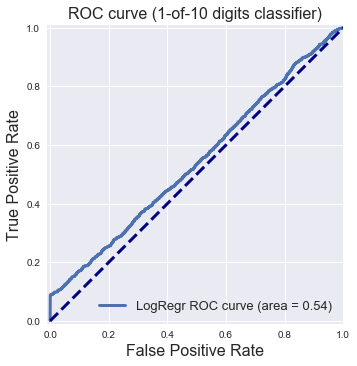

Validation set AUC:  0.542551232694


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def simple_support_vector():
    working_features = ['discount_percentage', 'judgment_amount', 'ticket_issued_days_to_2004', 'lat', 'lon']
    
    X_norm = normalize_scaler(X_work, working_features=working_features)
        
    X_train, X_validation, y_train, y_validation = train_test_split(X_norm, y_work, random_state=0, test_size=0.1)

    X_train_small = X_train.iloc[::1]
    
    y_train_small = y_train.iloc[::1]
    
    clf = SVC().fit(X_train_small, y_train_small.as_matrix())
    
    y_decision_fn_scores = clf.decision_function(X_validation) 
    
    fpr, tpr, _ = roc_curve(y_validation, y_decision_fn_scores)
    roc_auc = auc(fpr, tpr)
    
    plot_auc(y_validation, y_decision_fn_scores)

    print('Validation set AUC: ', roc_auc)
    
    return clf, working_features

clf_svm, working_features_svm =simple_support_vector()
    

In [9]:
def test_svm(clf, working_features, normalize = False):

    if normalize:
        X = normalize_scaler(X_test, working_features=working_features)
    else:
        X = X_test
        
    
    y_decision_fn_scores = clf.decision_function(X) 
    fpr, tpr, _ = roc_curve(y_test, y_decision_fn_scores)
    roc_auc = auc(fpr, tpr)
    plot_auc(y_test, y_decision_fn_scores)
    print('Test set AUC: ', roc_auc)
            
    accuracy_score = clf.score(X, y_test)
    
    print('Test Accuracy Score: {:.2f}'.format(accuracy_score)) 
    

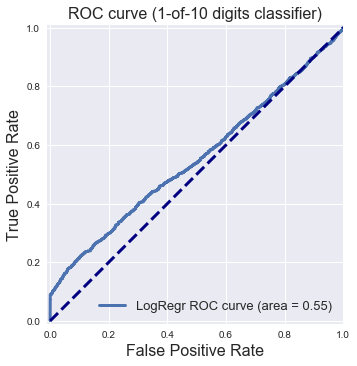

Test set AUC:  0.552183028345
Test Accuracy Score: 0.93


In [10]:
test_svm(clf_svm, working_features_svm, True)

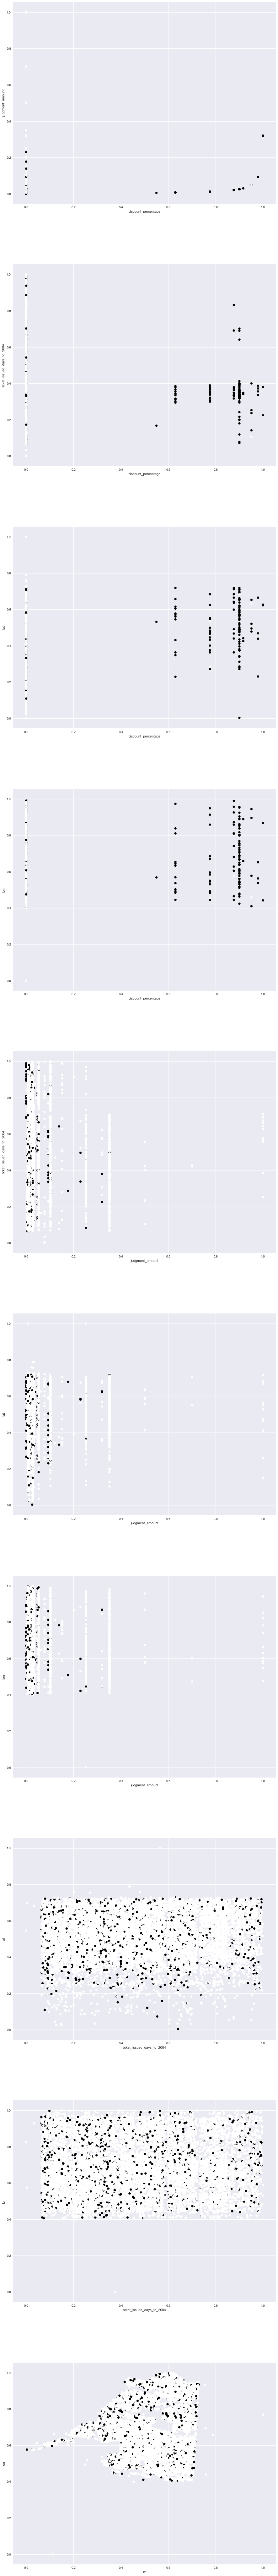

In [13]:
plot_test_2D(working_features_svm, True)

In [16]:
def normalize_feature(X, working_features):
    X_norm = pd.get_dummies(df[working_features], columns=["agency_name", "state",  'violation_code', 'disposition',], prefix=['agency_name', 'state', 'violation_code', 'disposition'])
        
    return X_norm.loc[X.index.values]

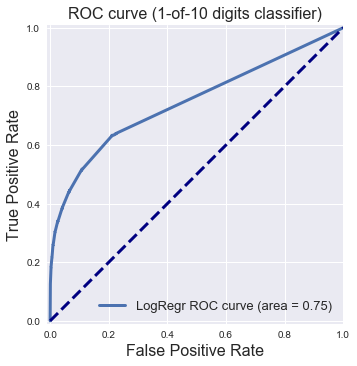

Validation set AUC:  0.746023184682
Validation set Accuracy Score: 0.94


In [22]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_solution():
    working_features = ['discount_percentage', 'agency_name', 'state', 'violation_code', 'disposition', 'judgment_amount', 'lat', 'lon']
    
    X_norm = normalize_feature(X_work, working_features)
    
    X_train, X_validation, y_train, y_validation = train_test_split(X_norm, y_work, random_state=0, test_size=0.1)

        
    clf = RandomForestClassifier().fit(X_train, y_train)
    
#     y_score = clf.decision_function(X_test[working_features])

    y_decision_fn_scores = clf.predict_proba(X_validation)[:,1]
        
    fpr, tpr, _ = roc_curve(y_validation, y_decision_fn_scores)
    roc_auc = auc(fpr, tpr)
    
    plot_auc(y_validation, y_decision_fn_scores)
    
#     plot_auc(y_test, y_score)

    print('Validation set AUC: ', roc_auc)

    accuracy_score = clf.score(X_validation, y_validation)

    print('Validation set Accuracy Score: {:.2f}'.format(accuracy_score)) 
    
    return clf, working_features

clf_rf, working_features_rf = random_forest_solution()

In [23]:
def test_tree(clf, working_features, normalize = False):

    if normalize:
        X = normalize_feature(X_test, working_features=working_features)
    else:
        X = X_test
    
    y_decision_fn_scores = clf.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_decision_fn_scores)
    roc_auc = auc(fpr, tpr)
    plot_auc(y_test, y_decision_fn_scores)
    print('Test set AUC: ', roc_auc)
            
    accuracy_score = clf.score(X, y_test)
    
    print('Test set Accuracy Score: {:.2f}'.format(accuracy_score))     

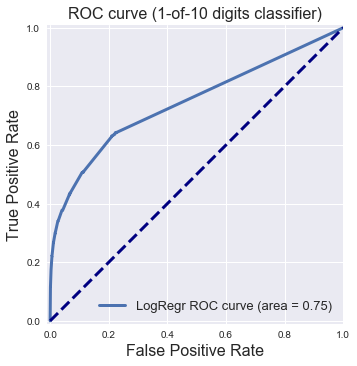

Test set AUC:  0.745282334949
Test set Accuracy Score: 0.93


In [24]:
test_tree(clf_rf, working_features_rf, True)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def tree_auc(estimator, X, y):
    y_decision_fn_scores = estimator.predict_proba(X)[:,1]
        
    fpr, tpr, _ = roc_curve(y, y_decision_fn_scores)
    
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

def grid_search_tree():
    working_features = ['discount_percentage', 'agency_name', 'state', 'violation_code', 'disposition', 'judgment_amount', 'lat', 'lon']

    X_norm = normalize_feature(X_work, working_features)
            
    clf = DecisionTreeClassifier()
    grid_values = {'max_depth': range(5,20)}
    
    grid_clf = GridSearchCV(clf, param_grid = grid_values, scoring = tree_auc)
    
    grid_clf.fit(X_norm, y_work)
    
    print('Grid best parameter (max. AUC): ', grid_clf.best_params_)
    print('Grid best score (AUC): ', grid_clf.best_score_)
    print(grid_clf.cv_results_['mean_test_score'])
    
    return grid_clf.best_params_

In [26]:
best_tree_depth = grid_search_tree()['max_depth']

Grid best parameter (max. AUC):  {'max_depth': 9}
Grid best score (AUC):  0.799363725079
[ 0.7945465   0.79586593  0.79767548  0.79783364  0.79936373  0.79705486
  0.79470906  0.78782406  0.78183246  0.77396945  0.76285304  0.75361711
  0.74204127  0.73412011  0.72654665]


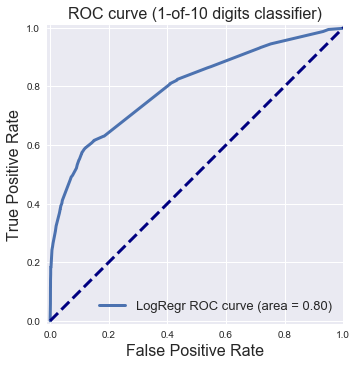

Validation set AUC:  0.796686769136
Validation set Accuracy Score: 0.94


In [27]:

def decision_tree_solution(max_depth):
    working_features = ['discount_percentage', 'agency_name', 'state', 'violation_code', 'disposition', 'judgment_amount', 'lat', 'lon']
    
    X_norm = normalize_feature(X_work, working_features)
    
    X_train, X_validation, y_train, y_validation = train_test_split(X_norm, y_work, random_state=0, test_size=0.1)
        
    clf = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train)
    
    y_decision_fn_scores = clf.predict_proba(X_validation)[:,1]
        
    fpr, tpr, _ = roc_curve(y_validation, y_decision_fn_scores)
    roc_auc = auc(fpr, tpr)
    
    plot_auc(y_validation, y_decision_fn_scores)
    
    print('Validation set AUC: ', roc_auc)

    accuracy_score = clf.score(X_validation, y_validation)

    print('Validation set Accuracy Score: {:.2f}'.format(accuracy_score))
    
    expanded_features = X_norm.columns.values
    
    return clf, working_features, expanded_features

clf_dt, working_features_dt, expanded_features_dt = decision_tree_solution(best_tree_depth)

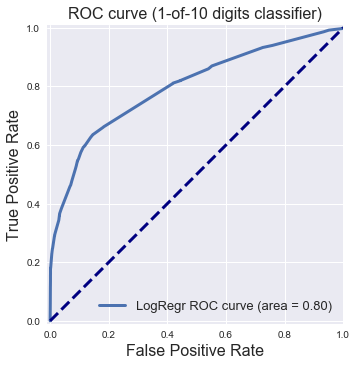

Test set AUC:  0.798830114624
Test set Accuracy Score: 0.94


In [28]:
test_tree(clf_dt, working_features_dt, True)

In [29]:
from adspy_shared_utilities import plot_decision_tree, plot_feature_importances

def plot_tree(clf, expanded_features):
    importances = clf.feature_importances_
    
    data = []
        
    for i in range(len(expanded_features)):
        data.append([expanded_features[i], importances[i]])
        
    result = pd.DataFrame(data, columns=['feature', 'importance'])
    
    print(result.sort_values('importance', ascending=False))


In [30]:
plot_tree(clf_dt, expanded_features_dt)

                                               feature  importance
259                 disposition_Responsible by Default    0.443626
1                                      judgment_amount    0.250437
0                                  discount_percentage    0.217581
2                                                  lat    0.020709
3                                                  lon    0.019134
211                           violation_code_9-1-36(a)    0.011216
258               disposition_Responsible by Admission    0.010160
5               agency_name_Department of Public Works    0.004544
100                             violation_code_22-2-61    0.003244
4    agency_name_Buildings, Safety Engineering & En...    0.001592
163                             violation_code_9-1-104    0.001549
6                agency_name_Detroit Police Department    0.001385
162                          violation_code_9-1-103(C)    0.001362
77                              violation_code_22-2-17    0.00

In [31]:
plot_decision_tree(clf_dt, expanded_features_dt, ['non-compliant', 'compliant'])

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH